# Investigate Convergence of Longstaff-Schwarz

In [32]:
# Packages used
import numpy as np
import matplotlib.pyplot as plt
from scipy import odr
from helper import *
import keras
from scipy.stats import norm
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [33]:
def GBM_exact(T, S, sigma, r, M):
    S_all = []
    S_all.append(S)
    dt = T/M
    Zm = np.random.normal(size=M)
    for i in range(M-1):
        S_all.append(S_all[i] * np.exp((r-0.5*sigma**2) * dt + sigma * np.sqrt(dt) * Zm[i])) 
    return S_all

## Investigation of the convergence of LSM method by increasing N 

In [34]:
# Variables used
T = M = N = 10
K = 1.1
S = 1
sigma = 0.2
r = 0.06
dt = T/M

In [35]:
exponent = 5
base = [10**i for i in range(1, exponent)]
option_mean = np.zeros(exponent - 1)
option_se = np.zeros(exponent - 1)

print(base)

[10, 100, 1000, 10000]


In [65]:
# Define one simulation

for ii in range(len(base)):

    trial_mean = []
    trial_se = []

    for jj in range(15):

        s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(base[ii])])
        [option_cash_flow, cash_flows] = value_option_schwarz(T,M,K,s_all, r, base[ii], order=2, option="put")

        for time in range(option_cash_flow.shape[1]):
            option_cash_flow[:,time]*=np.exp(-r*(time*dt))

        data = np.zeros(base[ii])
        data[0:len(option_cash_flow[option_cash_flow > 0])] = option_cash_flow[option_cash_flow > 0]

        trial_mean.append(np.mean(data))
        trial_se.append(np.std(data)/np.sqrt(base[ii]))
        

    option_mean[ii] = np.mean(trial_mean)
    option_se[ii] = np.mean(trial_se)

Regression failed. Inputs:
[0.37041072]
[0.54832182]
Regression failed. Inputs:
[1.05207692]
[0.12661326]


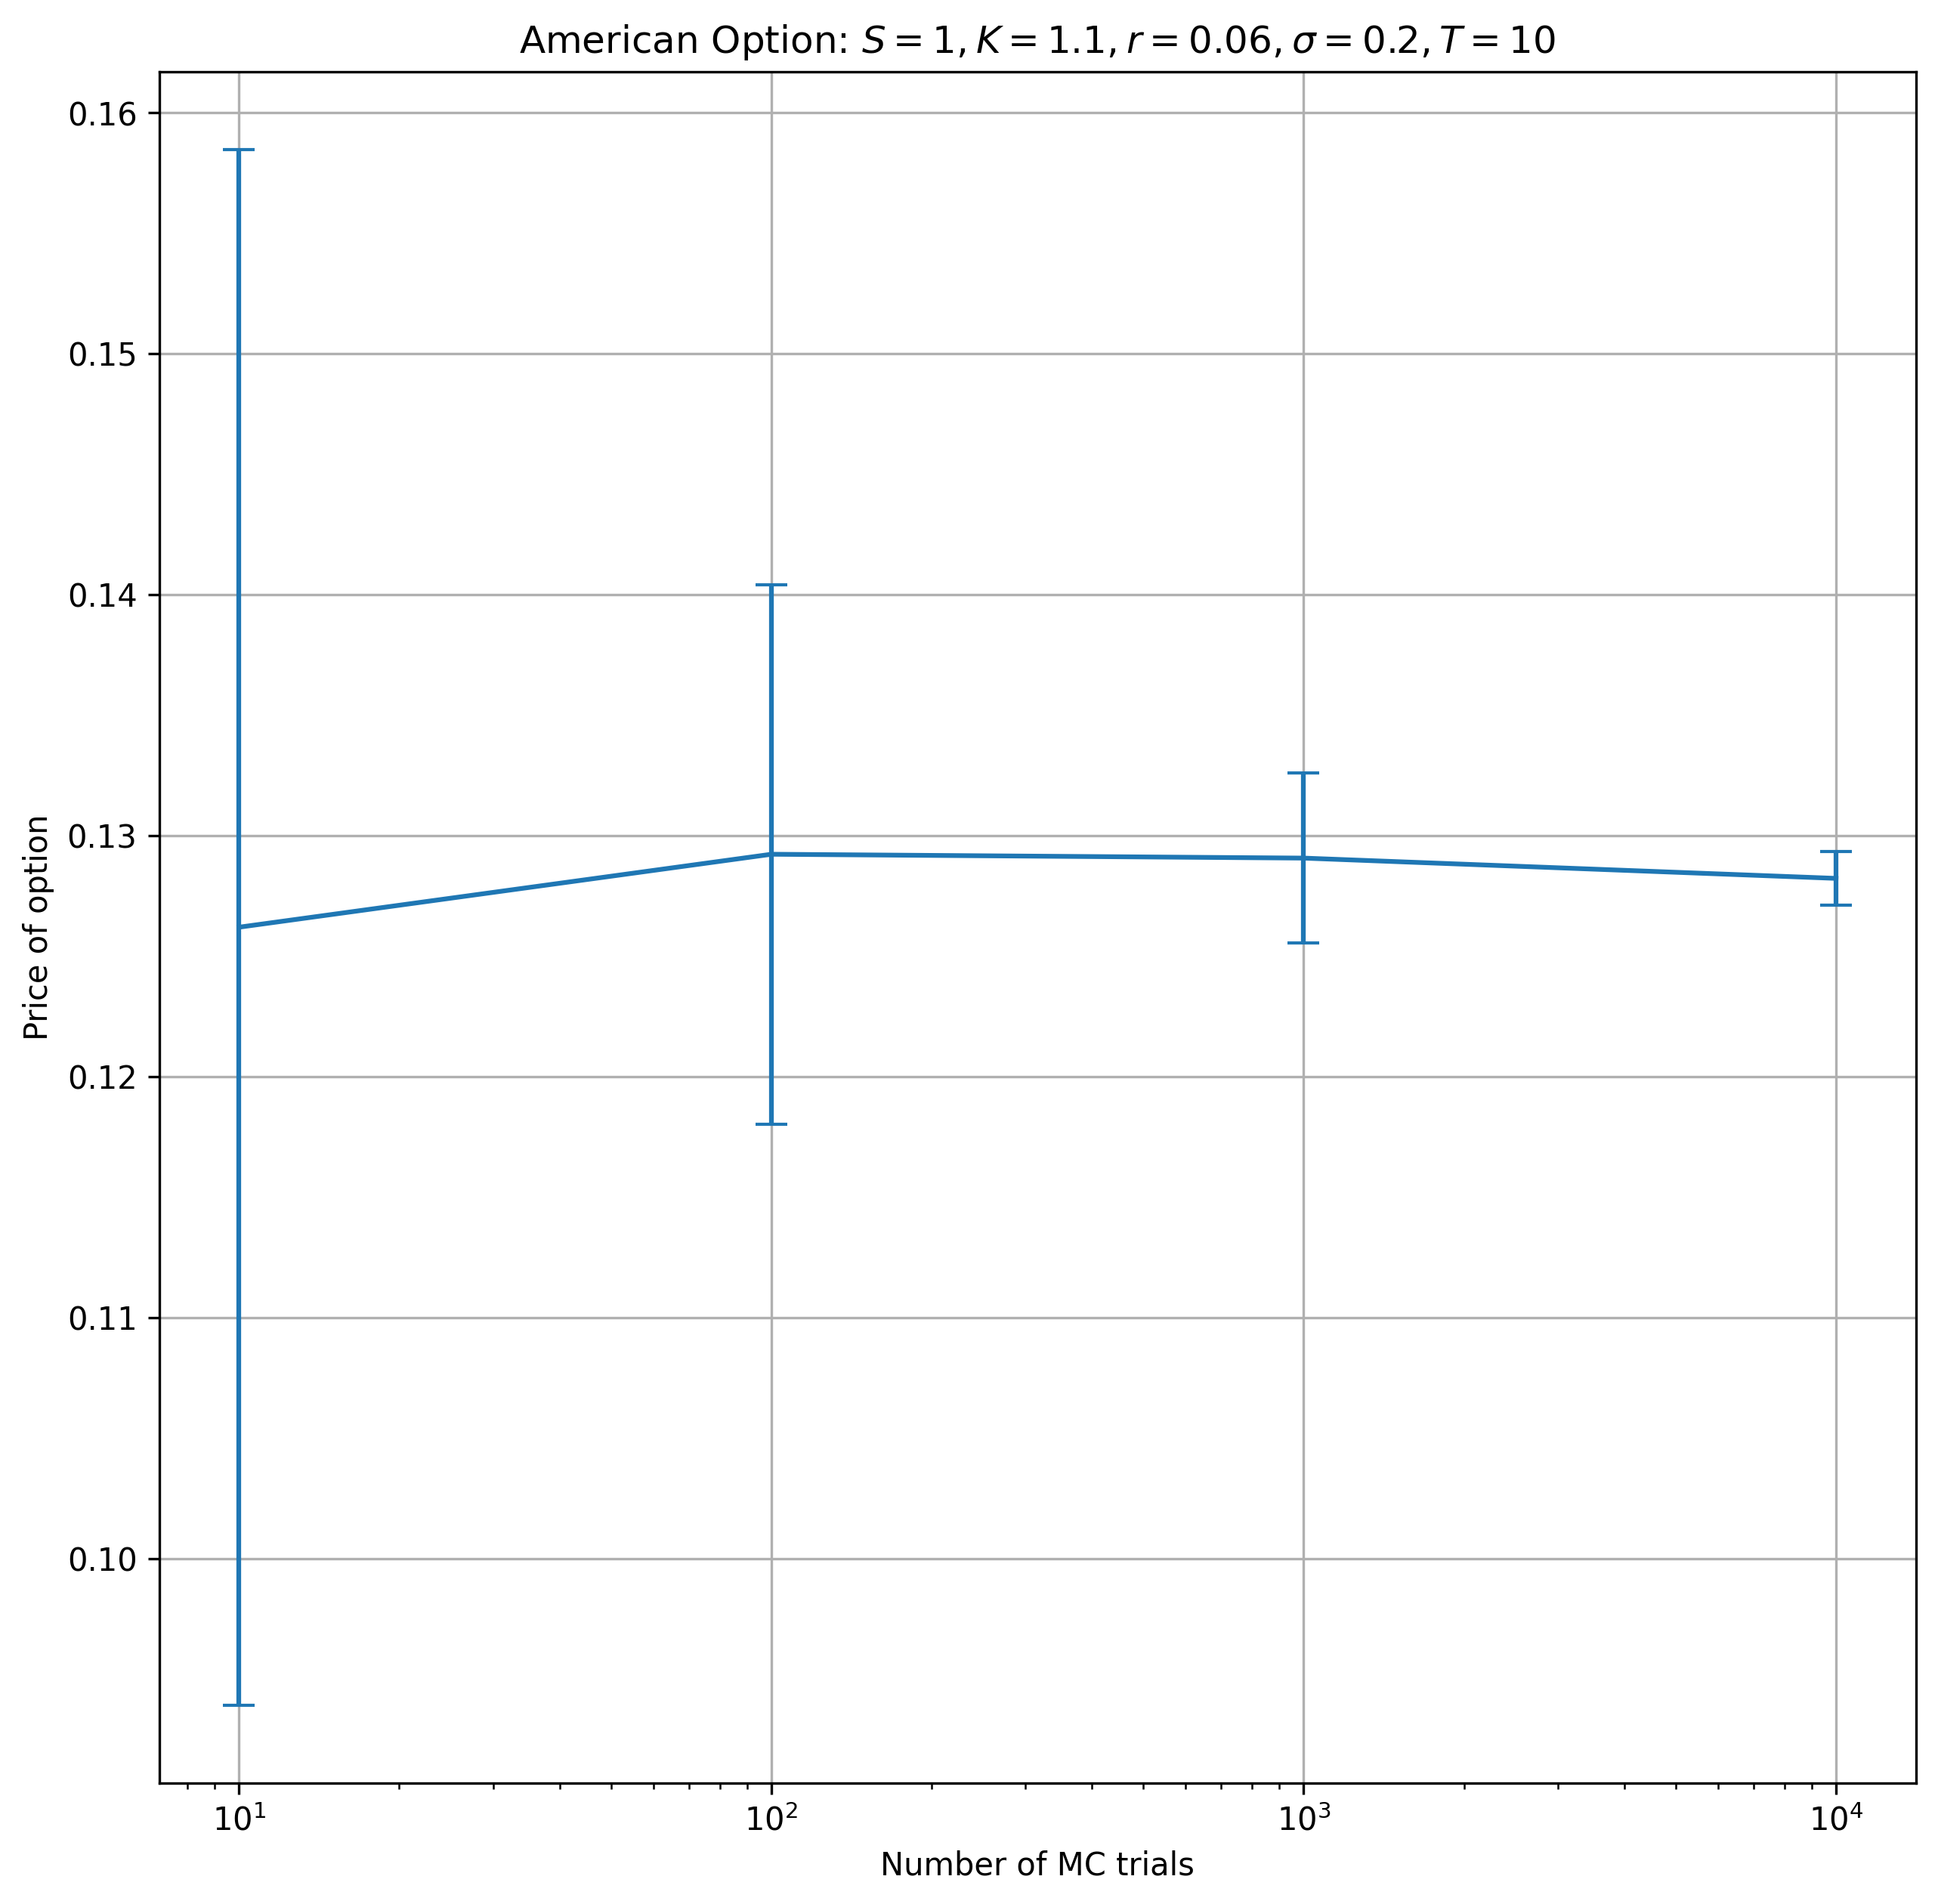

In [69]:
# Plot showing convergence of LSM
plt.figure(figsize=(10,10), dpi = 300)
plt.errorbar(base, option_mean, yerr = option_se, barsabove=True, capsize = 5)
plt.xscale('log')
plt.xlabel('Number of MC trials')
plt.ylabel('Price of option')
plt.grid()
plt.title(f'American Option: $S = {S}, K = {K}, r = {r}, \sigma = {sigma}, T = {T}$')
plt.savefig('figures/ls_convergece_nodes.jpg')
plt.show()

In [251]:
BSM_put(S, K, r, sigma, dt)

0.10031374008344551

## OFAT for sigma and strike price

Compute sensitivy plots for sigma and strike price for European and American put option

In [72]:
# Variables used
T = M = N = 10
S = 1
sigma = 0.2
r = 0.06
dt = T/M

In [73]:
# Create OFAT range
Ks = np.linspace(1., 1.5, 30)
sigmas = np.linspace(0.1, 0.5, 30)

In [74]:
# Apply OFAT
X, Y = np.meshgrid(Ks, sigmas)
europeans = BSM_put(S, X, r, Y, dt)

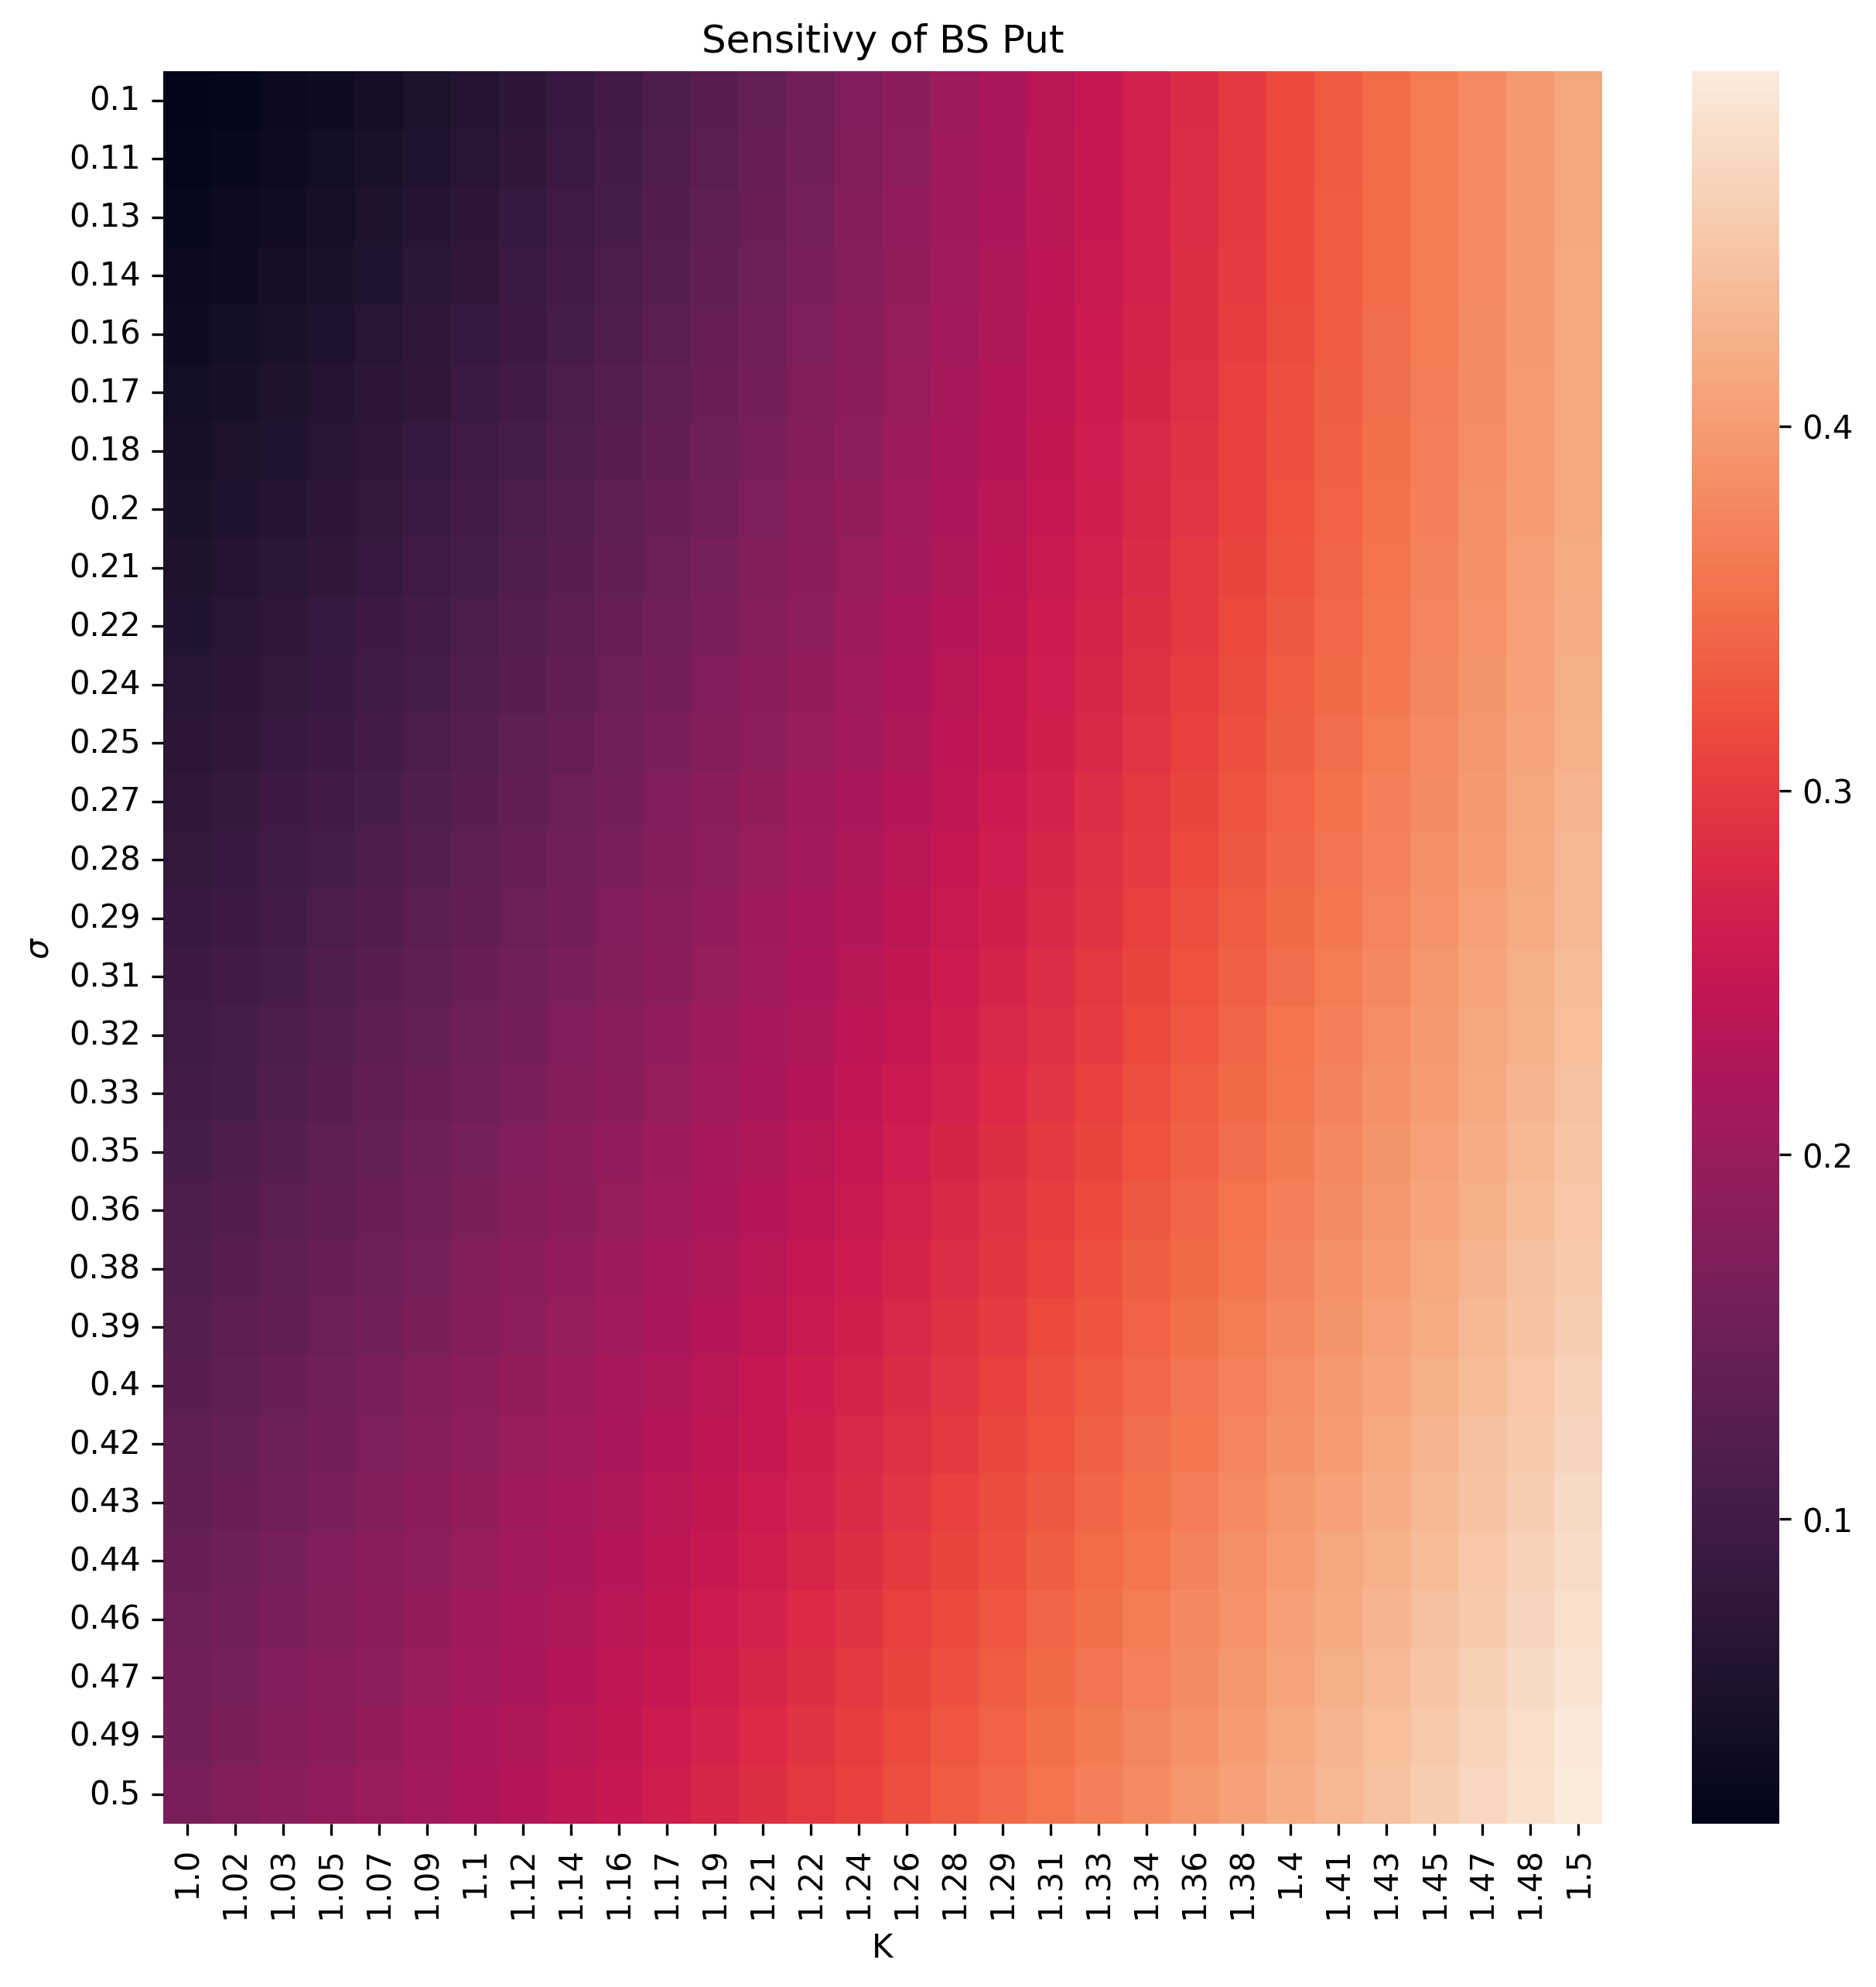

In [100]:
fig, ax = plt.subplots(figsize = (10,10), dpi = 300)
sns.heatmap(europeans, ax = ax, xticklabels = np.around(Ks, 2), yticklabels = np.around(sigmas,2))
ax.set_xlabel('K')
ax.set_ylabel('$\sigma$')
ax.set_title('Sensitivy of BS Put')
plt.savefig('figures/BS_sens.jpeg')
plt.show()

In [85]:
def LSM_sensitivities(K, sigma):
    
    trials = 2000
    s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(trials)])
    [option_cash_flow, cash_flows] = value_option_schwarz(T, M, K, s_all, r, trials, order = 2, option="put")

    for time in range(option_cash_flow.shape[1]):
        option_cash_flow[:,time]*=np.exp(-r*(time*dt))
    return np.sum(option_cash_flow)/trials

In [86]:
americans = np.zeros((len(Ks), len(sigmas)))
for ii in tqdm(range(len(Ks))):
    for jj in range(len(sigmas)):
        americans[ii][jj] = LSM_sensitivities(Ks[ii], sigmas[jj])

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:20<00:00,  2.68s/it]


In [87]:
np.save('data/ofat_americans.npy', americans)

In [88]:
americans = np.load('data/ofat_americans.npy')

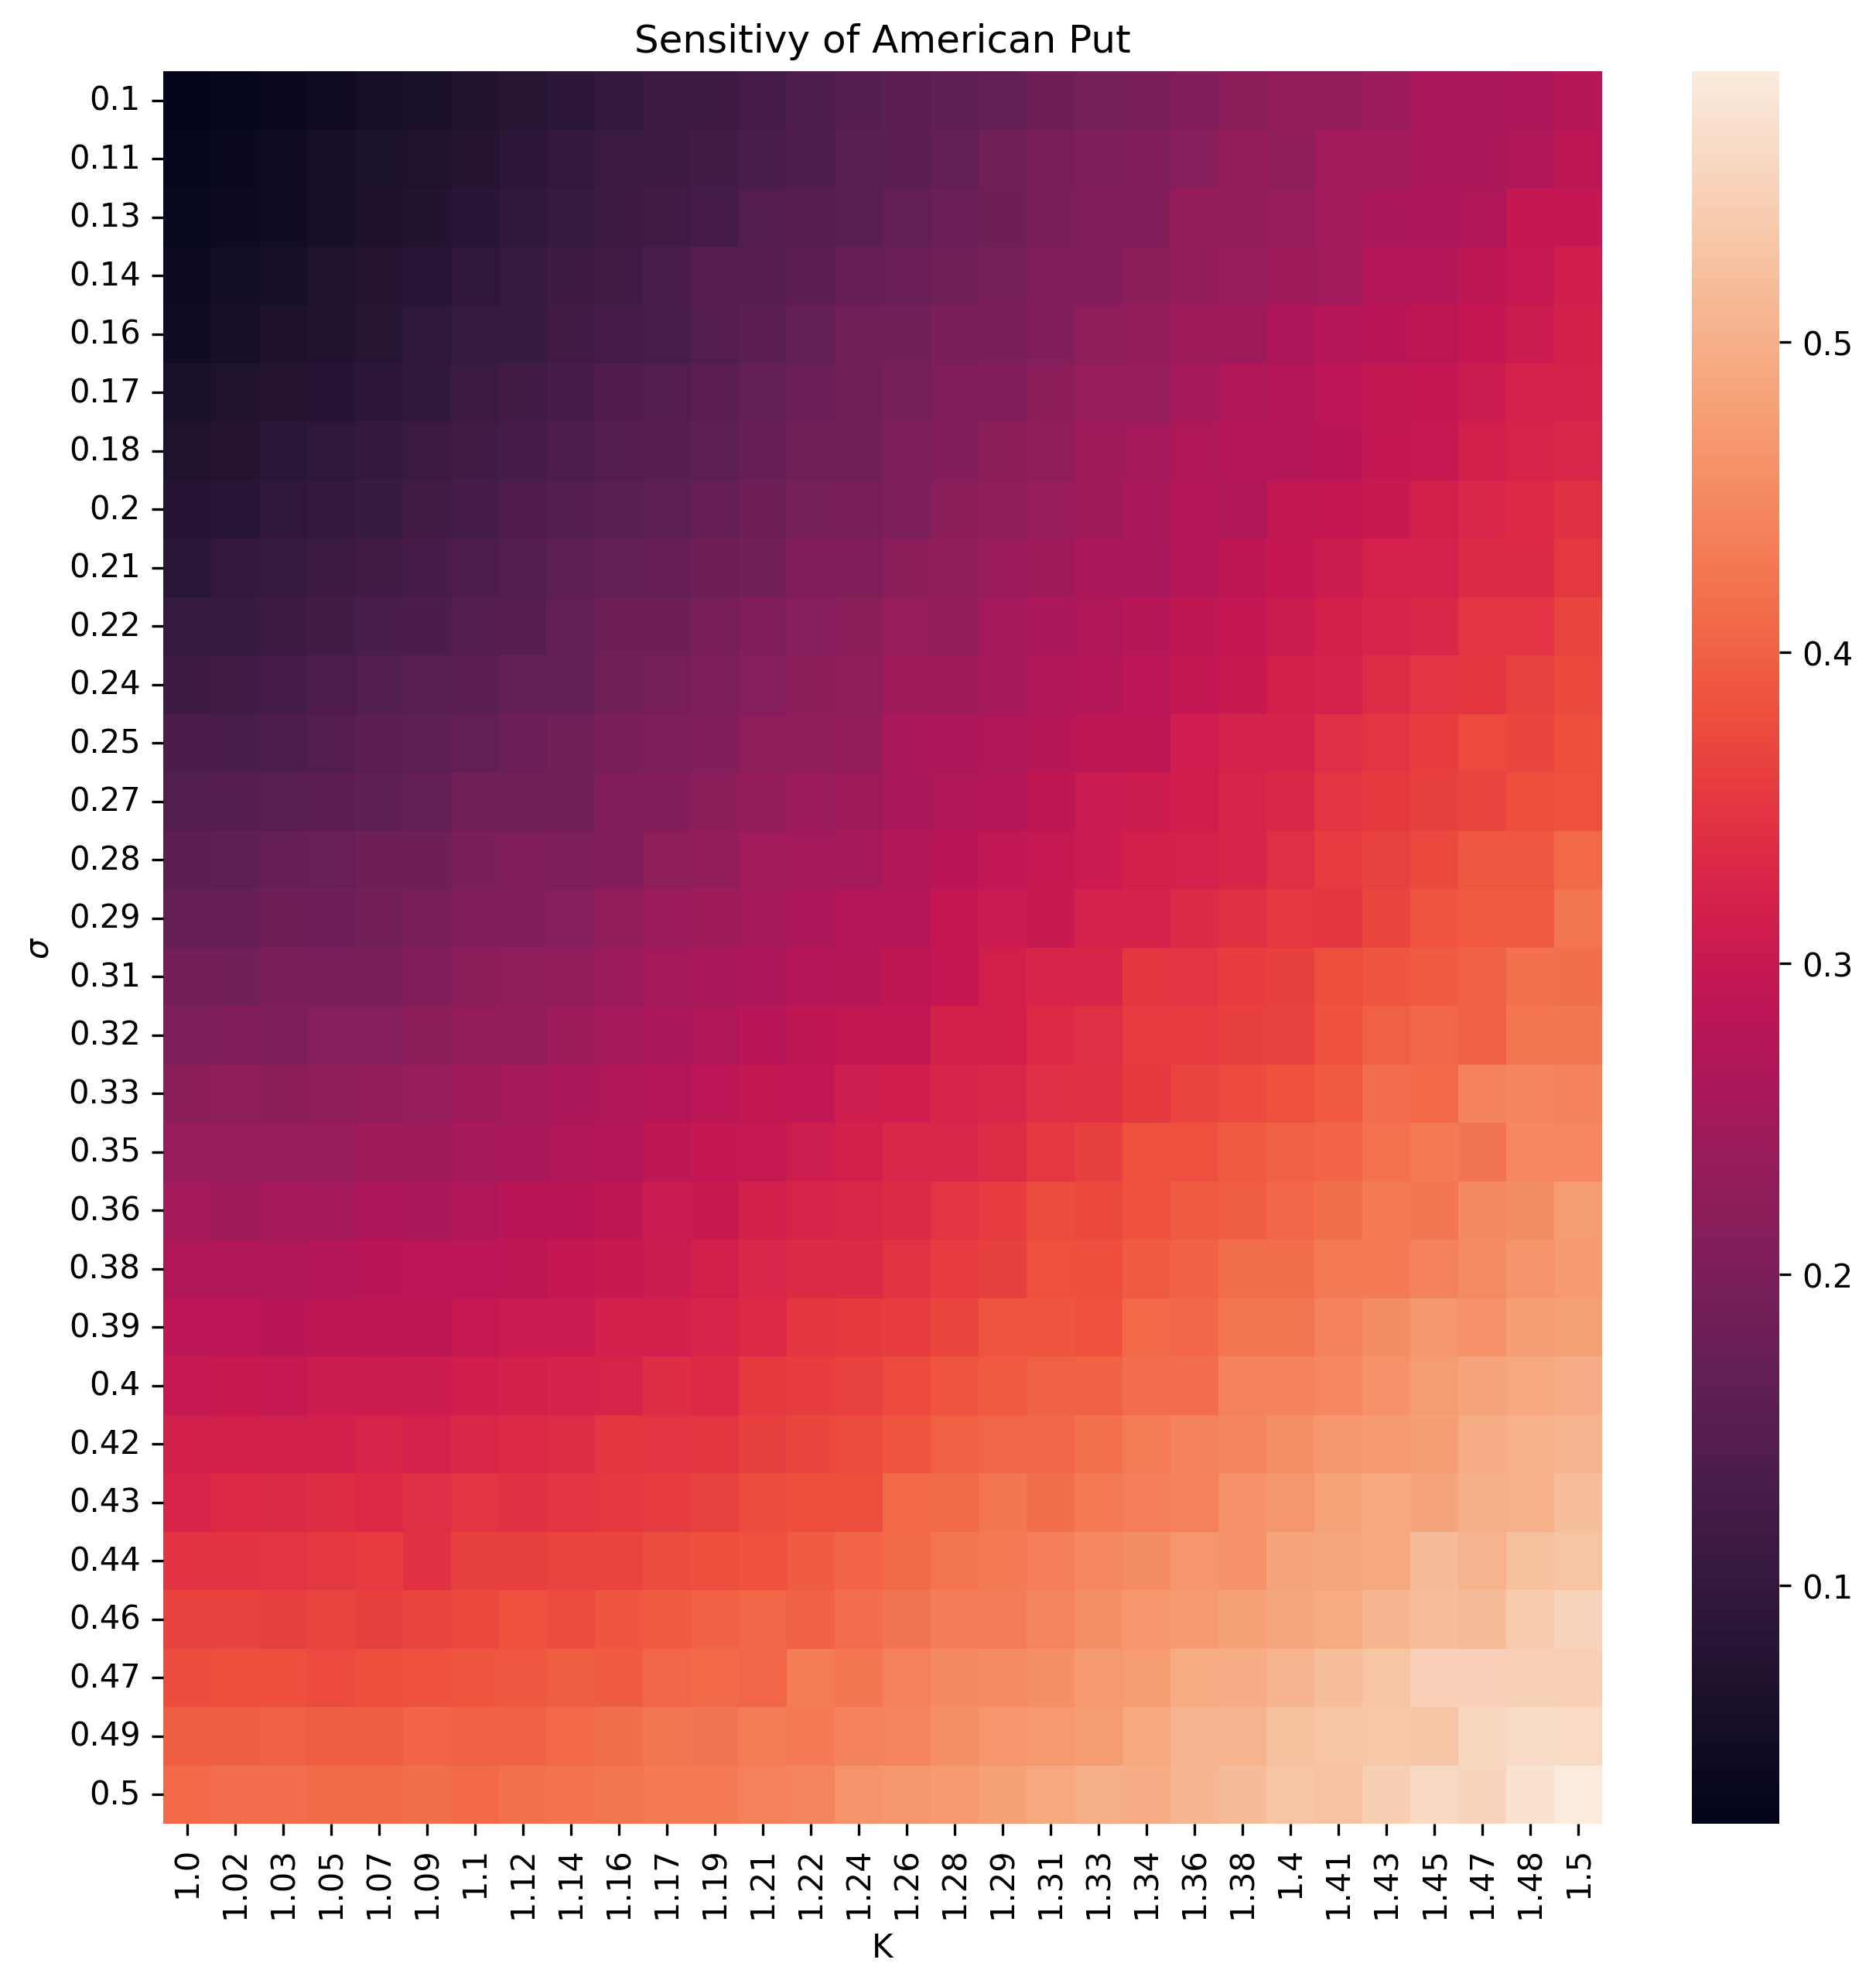

In [101]:
fig, ax = plt.subplots(figsize = (10,10), dpi = 300)
sns.heatmap(americans, ax = ax, xticklabels = np.around(Ks,2), yticklabels = np.around(sigmas,2))
ax.set_xlabel('K')
ax.set_ylabel('$\sigma$')
ax.set_title('Sensitivy of American Put')
plt.savefig('figures/American_sens.jpeg')
plt.show()

## Bermudan

In [92]:
def value_option_schwarz_bermudan(T,M,K,path_matrix, r, realizations, ex_dates, order=2,option="call", poly_choice="laguerre"):
    '''
    Longstaff-Scharwz option pricer
    '''
    dt = T/M
    stopping_rule = np.zeros(path_matrix.shape)
    cash_flows = np.zeros(path_matrix.shape)
    
    # save payoffs for later use
    if option == "call":
        exercise_value = np.maximum(path_matrix-K,0)
        stopping_rule[:,-1] = np.where(path_matrix[:,-1]-K>0, 1, 0)
        cash_flows[:,-1] = np.maximum(path_matrix[:,-1]-K,0)
    else:
        exercise_value = np.maximum(K-path_matrix,0)
        stopping_rule[:,-1] = np.where(K-path_matrix[:,-1]>0, 1, 0)
        cash_flows[:,-1] = np.maximum(K-path_matrix[:,-1],0)
        
    exercise_value[:,0] = 0

    for time in range(1,M-1):
        
        if time in ex_dates:
            # get X at time step and Y at time step+1 (Regress now) 
            if option == "call":
                X = np.where(path_matrix[:,M-time-1]>K, path_matrix[:,M-time-1], 0)
                Y = np.where(path_matrix[:,M-time-1]>K, cash_flows[:,M-time], 0)
            else:
                X = np.where(path_matrix[:,M-time-1]<K, path_matrix[:,M-time-1], 0)
                Y = np.where(path_matrix[:,M-time-1]<K, cash_flows[:,M-time], 0)

            X_nonzero = X[X>0]
            Y_nonzero = Y[X>0]
            Y_nonzero *= np.exp(-r * (dt*time))
            #Y_nonzero -= -20


            if len(Y_nonzero!=0):
                # perform regression
                try:
                    #print(f"In the money paths: {len(X_nonzero)}")
                    poly = np.polynomial.laguerre.Laguerre.fit(X_nonzero, Y_nonzero, order)
                except:
                    print("Regression failed. Inputs:")
                    print(X_nonzero)
                    print(Y_nonzero)
                final_y = poly(X_nonzero)

                ## Compare excerise with continuation
                ex_cont = np.zeros((len(X_nonzero), 2))

                if option == "call":
                    ex_cont[:,0] = X_nonzero - K
                else:
                    ex_cont[:,0] = K - X_nonzero
                ex_cont[:,1] = final_y

                j=0
                for i in range(len(X)):
                    if X[i] > 0:
                        if ex_cont[j,0] > ex_cont[j,1]:
                            stopping_rule[i,:] = 0
                            stopping_rule[i,M-time-1] = 1
                            cash_flows[i, :] = 0
                            cash_flows[i, M-time-1] = ex_cont[j,0]
                        j+=1      
            else:
                print(f"time: {time}")
                print("No path in-the-money-path found. Convergence issues expected")
    
    return stopping_rule * exercise_value, cash_flows

In [93]:
# Variables used
T = M = N = 10
K = 1.1
S = 1
sigma = 0.2
r = 0.06
dt = T/M
trials = 1000
exercise_dates = [1, 3, 5, 7, 9]

In [37]:
# Simulate stock prices
s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(trials)])

# Price Bermudan and American option
[option_cash_flow_br, cash_flows_br] = value_option_schwarz_bermudan(T,M,K,s_all, r, trials, exercise_dates, order=2, option="put")
[option_cash_flow, cash_flows] = value_option_schwarz(T,M,K,s_all, r, trials, order=2, option="put")

# Discount
for time in range(option_cash_flow.shape[1]):
        option_cash_flow[:,time]*=np.exp(-r*(time*dt))
        option_cash_flow_br[:,time]*=np.exp(-r*(time*dt))

# Terug slaan naar 1 vector
data = np.zeros(trials)
data_br = np.zeros(trials)
data[0:len(option_cash_flow[option_cash_flow > 0])] = option_cash_flow[option_cash_flow > 0]
data_br[0:len(option_cash_flow_br[option_cash_flow_br > 0])] = option_cash_flow_br[option_cash_flow_br > 0]

# Print results
print(f'European put {BSM_put(S, K, r, sigma, dt)}')
print(f'Bermudan put {np.mean(data_br)} +/- {np.std(data_br)/np.sqrt(trials)}')
print(f'American put {np.mean(data)} +/- {np.std(data)/np.sqrt(trials)}')

European put 0.10031374008344551
Bermudan put 0.1155466051934146 +/- 0.004117725462343555
American put 0.12527238237065236 +/- 0.003498318449770013


In [39]:
def LSM_sensitivities_bermudan(K, sigma):
    
    trials = 2000
    s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(trials)])
    [option_cash_flow, cash_flows] = value_option_schwarz_bermudan(T, M, K, s_all, r, trials, exercise_dates, order = 2, option="put")

    for time in range(option_cash_flow.shape[1]):
        option_cash_flow[:,time]*=np.exp(-r*(time*dt))
    return np.sum(option_cash_flow)/trials

In [40]:
# Create OFAT range
Ks = np.linspace(1., 1.5, 30)
sigmas = np.linspace(0.1, 0.5, 30)

In [41]:
bermudans = np.zeros((len(Ks), len(sigmas)))
for ii in tqdm(range(len(Ks))):
    for jj in range(len(sigmas)):
        bermudans[ii][jj] = LSM_sensitivities_bermudan(Ks[ii], sigmas[jj])
        

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:12<00:00,  2.42s/it]


In [44]:
# Save data
np.save('data/ofat_bermudan.npy', bermudans)

In [94]:
bermudans = np.load('data/ofat_bermudan.npy')

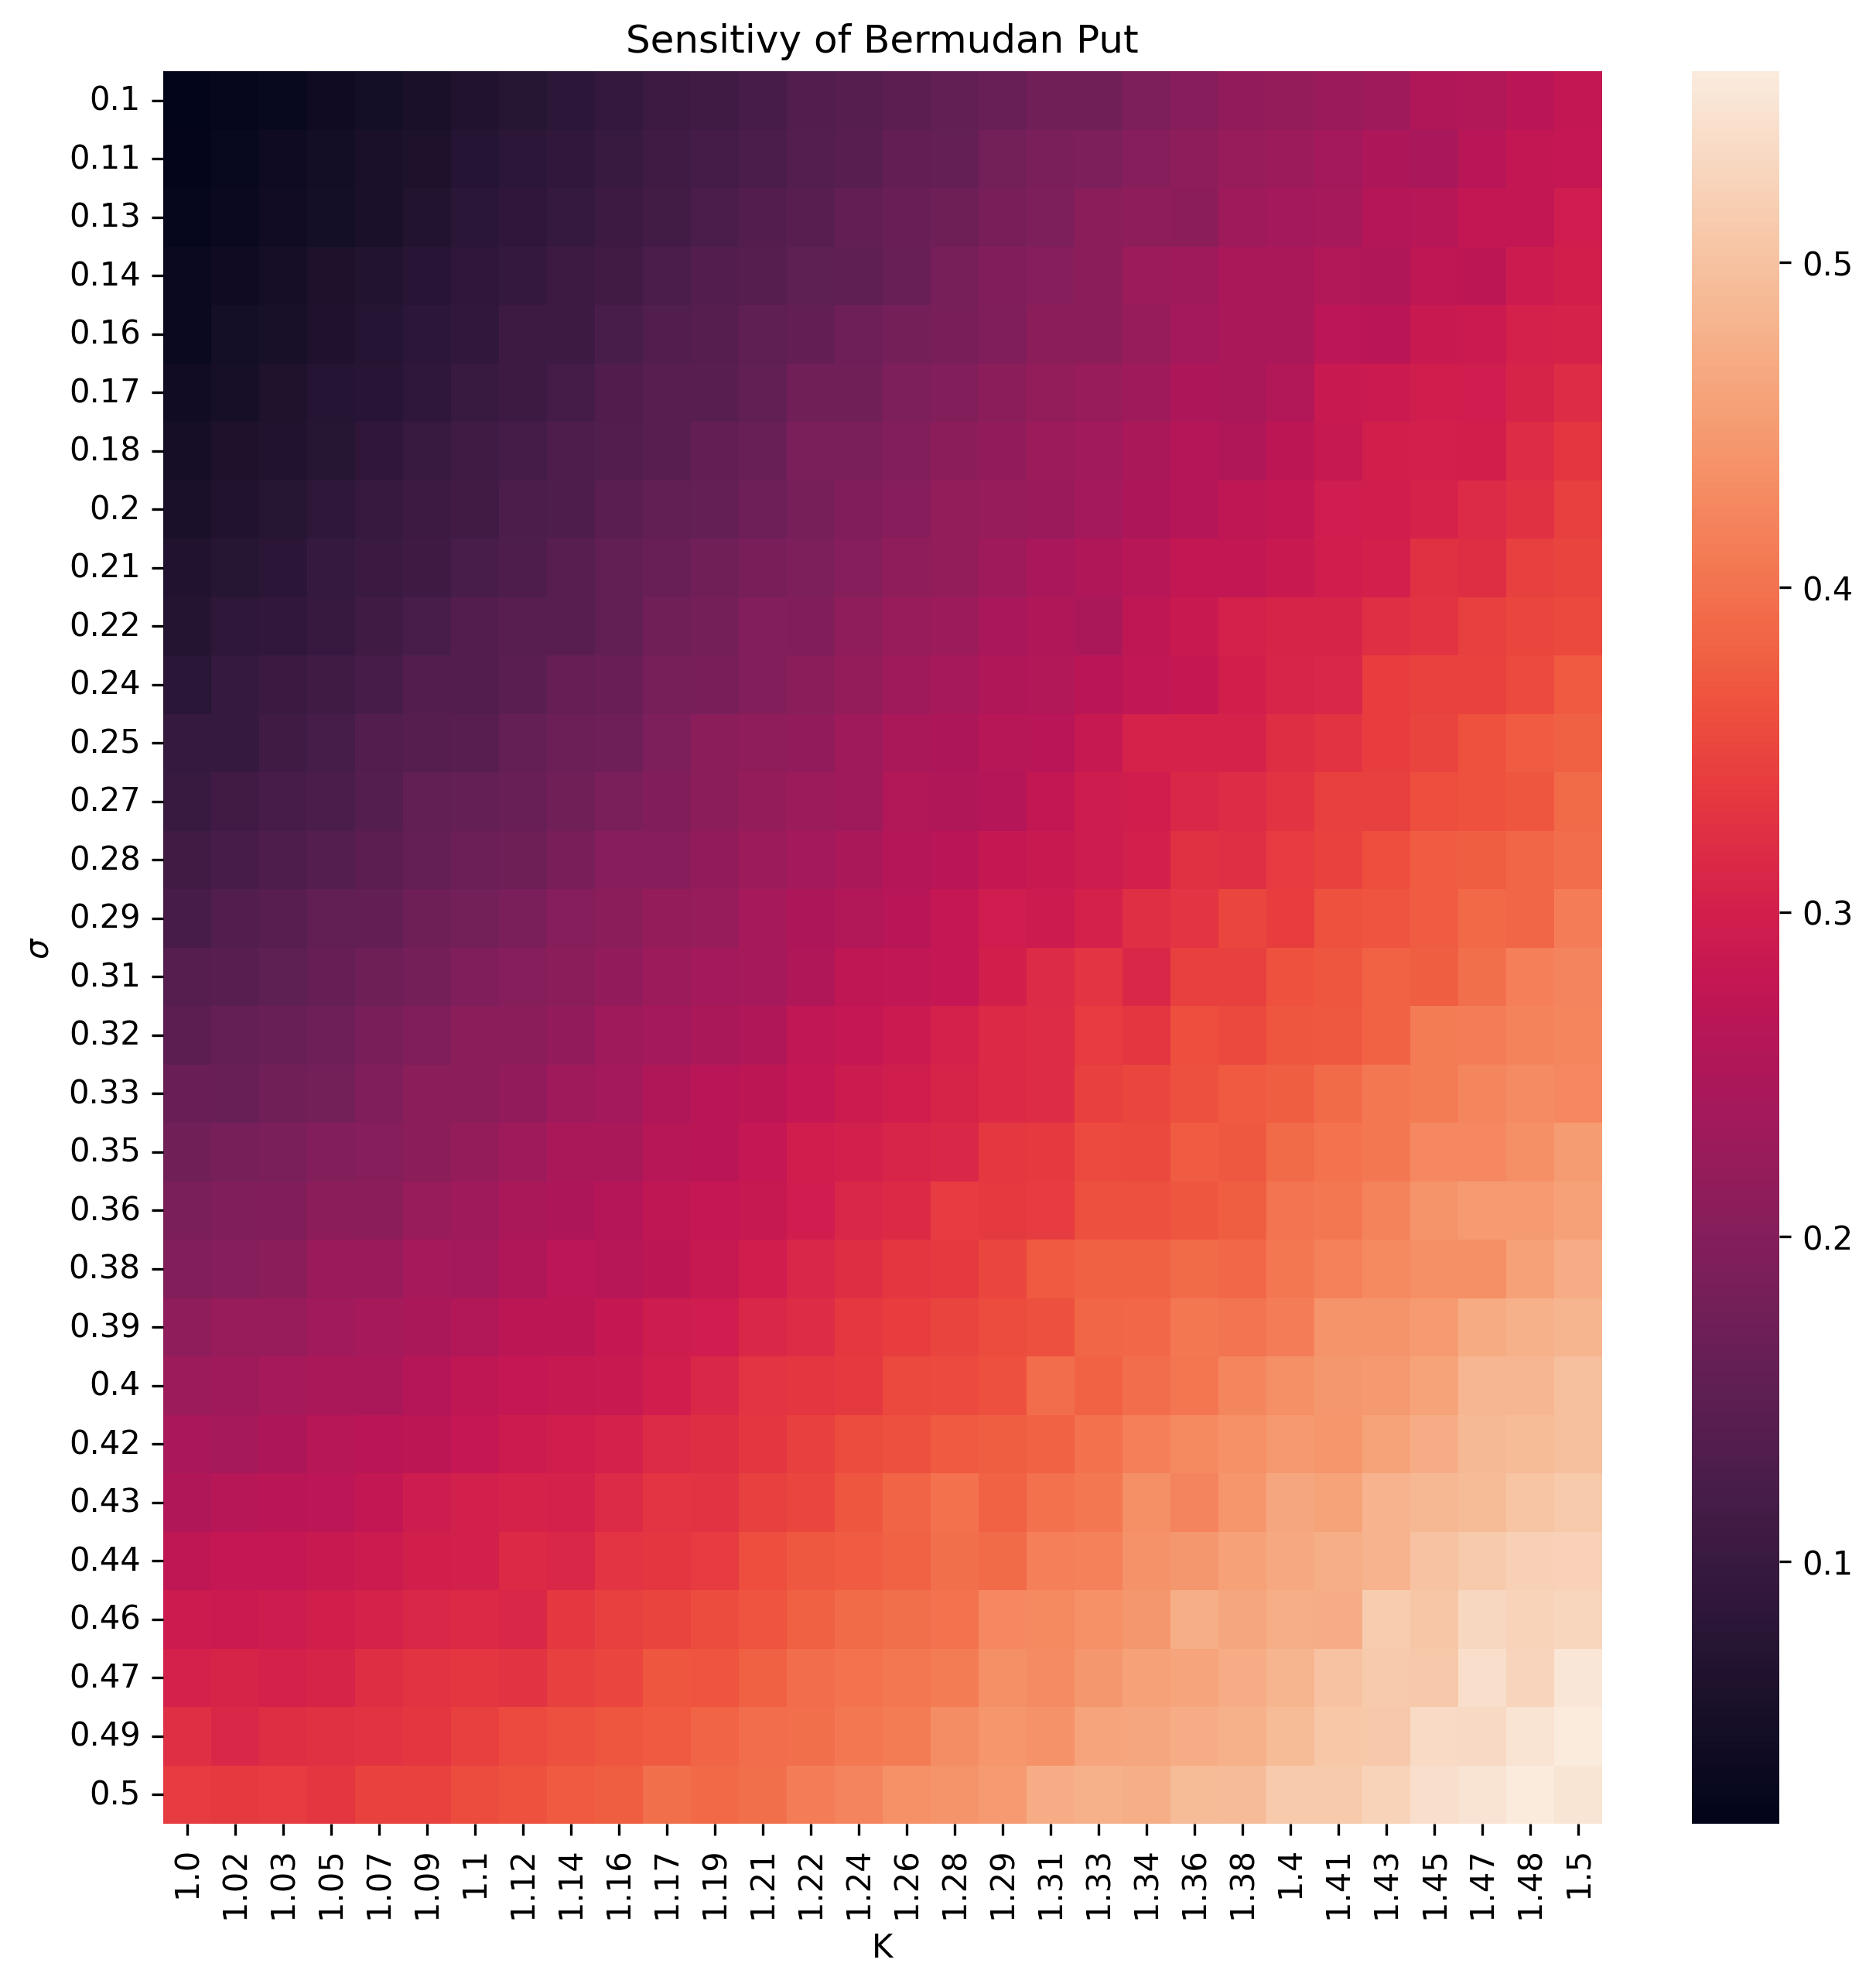

In [102]:
fig, ax = plt.subplots(figsize = (10,10), dpi = 300)
sns.heatmap(bermudans, ax = ax, xticklabels = np.around(Ks,2), yticklabels = np.around(sigmas,2))
ax.set_xlabel('K')
ax.set_ylabel('$\sigma$')
ax.set_title('Sensitivy of Bermudan Put')
plt.savefig('figures/Bermudan_sens.jpeg')
plt.show()